# Deep Research Project

Agentic AI Project to replicate OpenAI's Deep Research Agentic AI model. Using this reference primarily to start: https://www.analyticsvidhya.com/blog/2025/02/build-your-own-deep-research-agent/

## Project Setup / APIs etc.

Adding Project Root to path to import src files and cofig etc.

In [37]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)
    
# Now try importing
from src import get_openai_key

OpenAI API Key

In [38]:
OPENAI_API_KEY = get_openai_key()

Tavily API Key - Web Search Tool

In [39]:
from src import get_tavily_key

In [40]:
TAVILY_API_KEY = get_tavily_key()

### Define Agent State Schema - using LangGraph

In [41]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import Annotated, List, Optional, Literal

# defines structure for each section in the report
class Section(BaseModel):
    name: str = Field(
        description="Name for a particular section of the report.",
        )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
        )
    research: bool = Field(
        description="Whether to perform web search for this section of the report."
        )
    content: str = Field(
        description="The content for this section."
        )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="All the Sections of the overall report.",
        )

# defines structure for queries generated for deep research
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of web search queries.",
        )

# consists of input topic and output report generated
class ReportStateInput(TypedDict):
    topic: str # Report topic

class ReportStateOutput(TypedDict):
    final_report: str # Final report

# overall agent state which will be passed and updated in nodes in the graph
class ReportState(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections
    completed_sections: Annotated[list, operator.add] # Send() API
    report_sections_from_research: str # completed sections to write final sections
    final_report: str # Final report

# defines the key structure for sections written using the agent 
class SectionState(TypedDict):
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # completed sections to write final sections
    completed_sections: list[Section] # Final key in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key in outer state for Send() API

### Utility Functions

1. run_search_queries(...)

asynchronous search queries for a list of queries - returning results

In [42]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
import asyncio
from dataclasses import asdict, dataclass
from typing import Dict, Any, List, Union

# just to handle objects created from LLM reponses
@dataclass
class SearchQuery: #Creates a dataclass version of SearchQuery (different from your Pydantic model)
    search_query: str
    def to_dict(self) -> Dict[str, Any]: 
        return asdict(self)

tavily_search = TavilySearchAPIWrapper()

async def run_search_queries(
    search_queries: List[Union[str, SearchQuery]],
    num_results: int = 5,
    include_raw_content: bool = False
) -> List[Dict]:
    search_tasks = []
    for query in search_queries:
        # Handle both string and SearchQuery objects
        # Just in case LLM fails to generate queries as:
        # class SearchQuery(BaseModel):
        #     search_query: str
        query_str = query.search_query if isinstance(query, SearchQuery) else str(query) # text query
        try:
            # get results from tavily async (in parallel) for each search query
            search_tasks.append(
                tavily_search.raw_results_async(
                    query=query_str,
                    max_results=num_results,
                    search_depth='advanced',
                    include_answer=False,
                    include_raw_content=include_raw_content
                )
            )
        except Exception as e:
              print(f"Error creating search task for query '{query_str}': {e}")
              continue
    # Execute all searches concurrently and await results
    try:
        if not search_tasks:
            return []
        search_docs = await asyncio.gather(*search_tasks, return_exceptions=True)
        # Filter out any exceptions from the results
        valid_results = [
            doc for doc in search_docs
            if not isinstance(doc, Exception)
        ]
        return valid_results
    except Exception as e:
        print(f"Error during search queries: {e}")
        return []

2. format_search_query_results(...)

Extract content from Web search showing source, URL, and content

In [43]:
import tiktoken
from typing import List, Dict, Union, Any

def format_search_query_results(
    search_response: Union[Dict[str, Any], List[Any]],
    max_tokens: int = 2000,
    include_raw_content: bool = False
) -> str:
    encoding = tiktoken.encoding_for_model("gpt-4")
    sources_list = []

    # Handle different response formats if search results is a dict
    if isinstance(search_response, dict):
        if 'results' in search_response:
            sources_list.extend(search_response['results'])
        else:
            sources_list.append(search_response)
    # if search results is a list
    elif isinstance(search_response, list):
        for response in search_response:
            if isinstance(response, dict):
                if 'results' in response:
                    sources_list.extend(response['results'])
                else:
                    sources_list.append(response)
            elif isinstance(response, list):
                sources_list.extend(response)

    if not sources_list:
        return "No search results found."

    # Deduplicate by URL and keep unique sources (website urls)
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and 'url' in source:
            if source['url'] not in unique_sources:
                unique_sources[source['url']] = source

    # Format output
    formatted_text = "Content from web search:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source.get('title', 'Untitled')}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source.get('content', 'No content available')}\n===\n"

        if include_raw_content:
            # truncate raw webpage content to a certain number of tokens to prevent exceeding LLM max token window
            raw_content = source.get("raw_content", "")
            if raw_content:
                tokens = encoding.encode(raw_content)
                truncated_tokens = tokens[:max_tokens]
                truncated_content = encoding.decode(truncated_tokens)
                formatted_text += f"Raw Content: {truncated_content}\n\n"


    return formatted_text.strip()

test functions

In [44]:
docs = await run_search_queries(['Dulwich College'], include_raw_content=True)
output = format_search_query_results(docs, max_tokens=500, 
   include_raw_content=False)
print(output)

Content from web search:

Source Dulwich College - Wikipedia:
===
URL: https://en.wikipedia.org/wiki/Dulwich_College
===
Most relevant content from source: Dulwich College is a 2–18 private, day and boarding school for boys in Dulwich, London, England. As a public school, it began as the College of God's Gift, founded in 1619 by Elizabethan actor Edward Alleyn, with the original purpose of educating 12 poor scholars. It began to grow into a large school from 1857 and took its current form in 1870, when it moved into its current premises. [...] Appearance
move to sidebar hide
Coordinates: 51°26′22″N 00°05′03″W / 51.43944°N 0.08417°W / 51.43944; -0.08417
From Wikipedia, the free encyclopedia
Public school in London, England
| Dulwich College |
| --- |
|  |
|  |
| Address |
|  |
| 
Dulwich Common, Dulwich
London
,
SE21 7LD
England
|
| Coordinates | 51°26′22″N 00°05′03″W / 51.43944°N 0.08417°W / 51.43944; -0.08417 |
| Information |
| Type | Public school
Private day and boarding school |
|

## Report Planner

### Creating Default Report Template

Prompt guide for LLM to build report based on general structure

In [45]:
# Structure Guideline
DEFAULT_REPORT_STRUCTURE = """The report structure should focus on breaking-down the user-provided topic
                              and building a comprehensive report in markdown using the following format:


                              1. Introduction (no web search needed)
                                    - Brief overview of the topic area


                              2. Main Body Sections:
                                    - Each section should focus on a sub-topic of the user-provided topic
                                    - Include any key concepts and definitions
                                    - Provide real-world examples or case studies where applicable


                              3. Conclusion (no web search needed)
                                    - Aim for 1 structural element (either a list of table) that distills the main body sections
                                    - Provide a concise summary of the report


                              When generating the final response in markdown, if there are special characters in the text,
                              such as the dollar symbol, ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
                          """

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/var/folders/b9/7f7wyjx96sq26wl90hdfx3hw0000gn/T/ipykernel_79280/3399040039.py:2: SyntaxWarning: invalid escape sequence '\$'
  DEFAULT_REPORT_STRUCTURE = """The report structure should focus on breaking-down the user-provided topic


### Instruction Prompts for Report Planner

1. REPORT_PLAN_QUERY_GENERATOR_PROMT

Helps LLM get a list of q's based on topic to form report sections

In [46]:
REPORT_PLAN_QUERY_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

The report will be focused on the following topic:
{topic}

The report structure will follow these guidelines:
{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:
1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the depth and breadth needed for the report structure.
"""

2. REPORT_PLAN_SECTION_GENERATOR_PROMPT

LLM generating section structure according to specific output

In [47]:
REPORT_PLAN_SECTION_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:
{topic}

The report should follow this organizational structure:
{report_organization}

You should reflect on this additional context information from web searches to plan the main sections of the report:
{search_context}

Now, generate the sections of the report. Each section should have the following fields:
- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web search for this section of the report or not.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web search.
For example, introduction and conclusion will not require research because they will distill information from other parts of the report.
"""

### Node Function for Report Planner

combine prompts to generate queries based on user topic, search web and get infromation, use info to generate structure and sections of report

In [48]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

async def generate_report_plan(state: ReportState):
    """Generate the overall plan for building the report"""
    topic = state["topic"]
    print('--- Generating Report Plan ---')

    report_structure = DEFAULT_REPORT_STRUCTURE
    number_of_queries = 8

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = REPORT_PLAN_QUERY_GENERATOR_PROMPT.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries
    )

    try:
        # Generate queries
        results = structured_llm.invoke([
            SystemMessage(content=system_instructions_query),
            HumanMessage(content='Generate search queries that will help with planning the sections of the report.')
        ])
        # Convert SearchQuery objects to strings
        query_list = [
            query.search_query if isinstance(query, SearchQuery) else str(query)
            for query in results.queries
        ]
        # Search web and ensure we wait for results
        search_docs = await run_search_queries(
            query_list,
            num_results=5,
            include_raw_content=False
        )
        if not search_docs:
            print("Warning: No search results returned")
            search_context = "No search results available."
        else:
            search_context = format_search_query_results(
                search_docs,
                include_raw_content=False
            )
        # Generate sections
        system_instructions_sections = REPORT_PLAN_SECTION_GENERATOR_PROMPT.format(
            topic=topic,
            report_organization=report_structure,
            search_context=search_context
        )
        structured_llm = llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([
            SystemMessage(content=system_instructions_sections),
            HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")
        ])

        print('--- Generating Report Plan Completed ---')
        return {"sections": report_sections.sections}

    except Exception as e:
        print(f"Error in generate_report_plan: {e}")
        return {"sections": []}

## Section Builder

### Query Generator

1. REPORT_SECTION_QUERY_GENERATOR_PROMPT

helps the LLM generate a comprehensive list of questions for the topic of that specific section which needs to be built

In [49]:
REPORT_SECTION_QUERY_GENERATOR_PROMPT = """Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure that they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""


Node Function for Query Generator

In [50]:
def generate_queries(state: SectionState):
    """ Generate search queries for a specific report section """

    # Get state
    section = state["section"]
    print('--- Generating Search Queries for Section: '+ section.name +' ---')
    # Get configuration
    number_of_queries = 5
    # Generate queries
    structured_llm = llm.with_structured_output(Queries)
    # Format system instructions
    system_instructions = REPORT_SECTION_QUERY_GENERATOR_PROMPT.format(section_topic=section.description,                                                                       number_of_queries=number_of_queries)
    # Generate queries
    user_instruction = "Generate search queries on the provided topic."
    search_queries = structured_llm.invoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content=user_instruction)])

    print('--- Generating Search Queries for Section: '+ section.name +' Completed ---')
    return {"search_queries": search_queries.queries}

Node Function for web search

In [51]:
async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    print('--- Searching Web for Queries ---')
    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await run_search_queries(search_queries, num_results=6, include_raw_content=False)
    # Deduplicate and format sources
    search_context = format_search_query_results(search_docs, max_tokens=4000, include_raw_content=False)

    print('--- Searching Web for Queries Completed ---')
    return {"source_str": search_context}

### Section Writer

1. SECTION_WRITER_PROMPT

prompt to write conent section in a certain style

In [52]:
SECTION_WRITER_PROMPT = """You are an expert technical writer crafting one specific section of a technical report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language do not use complex words unnecessarily
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study if available
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material obtained from web searches to help write the section:
{context}

5. Quality Checks:
- Format should be Markdown
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or bullet list) and only if it helps clarify your point
- One specific example / case study if available
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/b9/7f7wyjx96sq26wl90hdfx3hw0000gn/T/ipykernel_79280/4210525775.py:1: SyntaxWarning: invalid escape sequence '\$'
  SECTION_WRITER_PROMPT = """You are an expert technical writer crafting one specific section of a technical report.


Node Function for Section Writer

In [53]:
def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]
    print('--- Writing Section : '+ section.name +' ---')
    # Format system instructions
    system_instructions = SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                       section_topic=section.description,
                                                       context=source_str)
    # Generate section
    user_instruction = "Generate a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])
    # Write content to the section object
    section.content = section_content.content

    print('--- Writing Section : '+ section.name +' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

### Section Builder Sub-Agent

Sub-agent called several times in parallel for each section to get content and write up specific section. Using LangGraph Send Construct

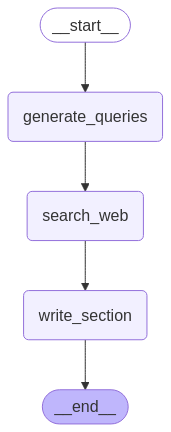

In [54]:
from langgraph.graph import StateGraph, START, END

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)
section_builder_subagent = section_builder.compile()

# Display the graph
from IPython.display import display, Image
Image(section_builder_subagent.get_graph().draw_mermaid_png())


### Parallelise Section Writing

LangGraph Send() used to parallelise and call sub-agent builder

In [55]:
from langgraph.constants import Send


def parallelize_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report in parallel and then write the section"""


    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder_with_web_search", # name of the subagent node
             {"section": s})
            for s in state["sections"]
              if s.research
    ]

## Format Section

### Format Section Node Function

Allsections are formatted and combined into 1 document

In [56]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of report sections into a single text string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research:
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

def format_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """

    print('--- Formatting Completed Sections ---')
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    print('--- Formatting Completed Sections is Done ---')
    return {"report_sections_from_research": completed_report_sections}

## Final Section Writer

1. FINAL_SECTION_WRITER_PROMPT

LLM generates intro or conc using guidelines. Content of already written sections are sent.

In [57]:
FINAL_SECTION_WRITER_PROMPT = """You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Available report content of already completed sections:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5"""

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/b9/7f7wyjx96sq26wl90hdfx3hw0000gn/T/ipykernel_79280/1591155706.py:1: SyntaxWarning: invalid escape sequence '\$'
  FINAL_SECTION_WRITER_PROMPT = """You are an expert technical writer crafting a section that synthesizes information from the rest of the report.


### Node Function for Final Sections

In [58]:
def write_final_sections(state: SectionState):
    """ Write the final sections of the report, which do not require web search and use the completed sections as context"""

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    print('--- Writing Final Section: '+ section.name + ' ---')
    # Format system instructions
    system_instructions = FINAL_SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                             section_topic=section.description,
                                                             context=completed_report_sections)

    # Generate section
    user_instruction = "Craft a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])

    # Write content to section
    section.content = section_content.content

    print('--- Writing Final Section: '+ section.name + ' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

Parallelisation for Final Section Writing

In [59]:
from langgraph.constants import Send

def parallelize_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections",
             {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
                 for s in state["sections"]
                    if not s.research #defines no research --> into / conc
    ]

## Compile Final Report

Node Function to Complie Report

In [60]:
def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    print('--- Compiling Final Report ---')
    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    # Escape unescaped $ symbols to display properly in Markdown
    formatted_sections = all_sections.replace("\\$", "TEMP_PLACEHOLDER")  # Temporarily mark already escaped $
    formatted_sections = formatted_sections.replace("$", "\\$")  # Escape all $
    formatted_sections = formatted_sections.replace("TEMP_PLACEHOLDER", "\\$")  # Restore originally escaped $

    # Now escaped_sections contains the properly escaped Markdown text
    print('--- Compiling Final Report Done ---')
    return {"final_report": formatted_sections}

## Build Deep Research Agent

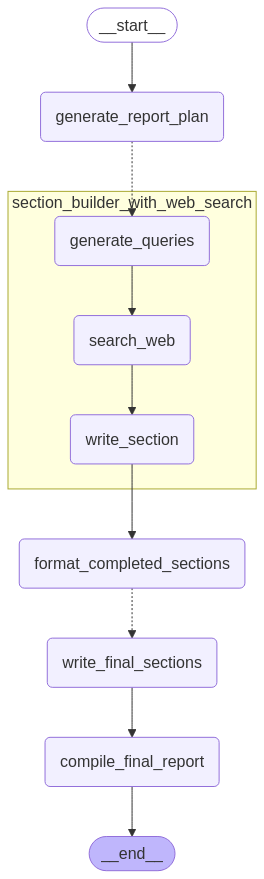

In [61]:
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput)

builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder_with_web_search", section_builder_subagent)
builder.add_node("format_completed_sections", format_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan",
                              parallelize_section_writing,
                              ["section_builder_with_web_search"])
builder.add_edge("section_builder_with_web_search", "format_completed_sections")
builder.add_conditional_edges("format_completed_sections",
                              parallelize_final_section_writing,
                              ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

reporter_agent = builder.compile()
# view agent structure
display(Image(reporter_agent.get_graph(xray=True).draw_mermaid_png()))

## Run and Test Agent

The interface for using your Deep Research agent in the notebook environment, making it easy to trigger the entire workflow and see the results.

In [62]:
from IPython.display import display
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown

async def call_planner_agent(agent, prompt, config={"recursion_limit": 50}, verbose=False):
    events = agent.astream(
        {'topic' : prompt},
        config,
        stream_mode="values",
    )

    async for event in events:
        for k, v in event.items():
            if verbose:
                if k != "__end__":
                    display(RichMarkdown(repr(k) + ' -> ' + repr(v)))
            if k == 'final_report':
                print('='*50)
                print('Final Report:')
                md = RichMarkdown(v)
                display(md)

Test Run

In [63]:
topic = "Detailed report on how is NVIDIA winning the game against its competitors"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: NVIDIA's Market Dominance ---
--- Generating Search Queries for Section: Technological Innovations and Product Offerings ---
--- Generating Search Queries for Section: Strategic Acquisitions and Partnerships ---
--- Generating Search Queries for Section: Financial Performance and Growth ---
--- Generating Search Queries for Section: Challenges and Future Prospects ---
--- Generating Search Queries for Section: Financial Performance and Growth Completed ---
--- Generating Search Queries for Section: NVIDIA's Market Dominance Completed ---
--- Generating Search Queries for Section: Challenges and Future Prospects Completed ---
--- Searching Web for Queries ---
--- Searching Web for Queries ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Strategic Acquisitions and Partnerships Completed ---
--- Searching Web for Queries ---
--- Generating Sear

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

NVIDIA stands as a formidable leader in the technology market, particularly in the GPU industry, where it commands 
a significant market share. This report delves into NVIDIA's strategic maneuvers that have enabled it to outperform
competitors like AMD and Intel. By exploring NVIDIA's technological innovations, strategic acquisitions, and       
financial strategies, we aim to understand the factors contributing to its market dominance. Additionally, the     
report will address the challenges NVIDIA faces and its future prospects in an increasingly competitive landscape. 
Through this analysis, we seek to uncover the key elements driving NVIDIA's sustained success and market           
leadership.                                                                                                        


                                             NVIDIA's Market Dominance                                             

NVIDIA commands an overwhelming 90% of the GPU market share as of Q4 2024, underscoring its dominance over AMD and 
Intel. This market position is attributed to several factors, including NVIDIA's advanced GPU architectures like   
Blackwell, which significantly enhance AI and gaming performance. NVIDIA's strategic focus on AI workloads and     
high-performance computing has further solidified its leadership. For instance, the Blackwell architecture, with   
its 208 billion transistors, exemplifies NVIDIA's commitment to cutting-edge technology.                           

Despite a slight decline in discrete desktop GPU market share in late 2024, NVIDIA maintained an 82% share, while  
AMD and Intel gained marginally. This shift was partly due to NVIDIA reallocating production capacity to datacenter
GPUs, reflecting its strategic pivot towards AI and cloud computing markets. NVIDIA's ability to adapt and         
innovate, as seen with its RTX 40-series GPUs, continues to set it apart from competitors.                         

                                                      Sources                                                      

 • Nvidia's GPU market share hits 90% in Q4 2024:                                                                  
   https://www.techpowerup.com/forums/threads/nvidias-gpu-market-share-hits-90-in-q4-2024-gets-closer-to-full-monop
   oly.329842/                                                                                                     
 • AMD grabs GPU market share from Nvidia as GPU shipments rise:                                                   
   https://www.tomshardware.com/tech-industry/amd-grabs-a-share-of-the-gpu-market-from-nvidia-as-gpu-shipments-rise
   -slightly-in-q4                                                                                                 
 • Nvidia's GPU Market Dominance: A Closer Look:                                                                   
   https://www.ainvest.com/news/nvidia-s-gpu-market-dominance-a-closer-look-24121010c746fbbafd805832/              


                                  Technological Innovations and Product Offerings                                  

NVIDIA's advancements in AI and machine learning are revolutionizing industries through cutting-edge technologies  
and strategic partnerships. At Computex 2024, NVIDIA unveiled the Blackwell platform and Spectrum-X Ethernet       
network, showcasing innovations in AI and computing. The Blackwell GPU architecture, a successor to the Ampere     
series, offers significant improvements in AI processing capabilities, making it a leader in AI applications.      
NVIDIA's CUDA architecture, with over 48 milli